# Data challenge 1 #
## Dan Hannah, Healthcare Data Science Fellow ##
First, I'm going to use Pandas to read the data into this Jupyter notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

In [2]:
employee_data = pd.read_csv("employee_retention_data.csv")  # Read data from CSV into Pandas DataFrame.
print(employee_data.head())  # Visualize the table to provide a sense of how the raw data is structured.

   employee_id  company_id              dept  seniority    salary   join_date  \
0      13021.0           7  customer_service         28   89000.0  2014-03-24   
1     825355.0           7         marketing         20  183000.0  2013-04-29   
2     927315.0           4         marketing         14  101000.0  2014-10-13   
3     662910.0           7  customer_service         20  115000.0  2012-05-14   
4     256971.0           2      data_science         23  276000.0  2011-10-17   

    quit_date  
0  2015-10-30  
1  2014-04-04  
2         NaN  
3  2013-06-07  
4  2014-08-22  


To create an auxillary table showing headcount per day per company, I'm going to create a few helper functions to keep the code clean.

In [3]:
def day_as_dt(day):
    """Converts a day string (yyyy-mm-dd) to a Python datetime object."""
    if isinstance(day, str):
        return dt.strptime(day, "%Y-%m-%d")
    else:
        return None  # For NaN dates (i.e. people who haven't quit)


def get_employee_delta(day, emp_df):
    """Gets the net change in employees on a given day."""
    # day = str(day).split(" ")[0]
    joined = len(emp_df.loc[emp_df["join_date"] == day])
    quit = len(emp_df.loc[emp_df["quit_date"] == day])
    return joined - quit

I'll begin by creating a 3-column table in the form of a Pandas DataFrame.  The three columns will be:

1. Day
2. Company ID
3. Employee headcount

In [4]:
company_ids = employee_data["company_id"].unique()  # Get all unique company IDs.

# Define a range of days to examine the headcount for.
first_day = "2011-01-23"
last_day = "2015-12-13"
day_range = pd.date_range(start=first_day, end=last_day)

# Create an empty dict to populate.
headcount_dict = {"day": [], "company_id": [], "headcount": []}
for c_id in company_ids:
    emp_at_company = employee_data.loc[employee_data["company_id"] == c_id]
    headcount = 0
    for day in day_range:
        day = str(day).split(" ")[0]
        delta_employee = get_employee_delta(day, emp_at_company)
        headcount += delta_employee
        headcount_dict["day"].append(day)
        headcount_dict["company_id"].append(c_id)
        headcount_dict["headcount"].append(headcount)

# Convert this to a DataFrame.
headcount_df = pd.DataFrame.from_dict(headcount_dict)

In [5]:
print(headcount_df.head())  # Confirmation that the table is structured appropriately.

   company_id         day  headcount
0           7  2011-01-23          0
1           7  2011-01-24          1
2           7  2011-01-25          1
3           7  2011-01-26          1
4           7  2011-01-27          1


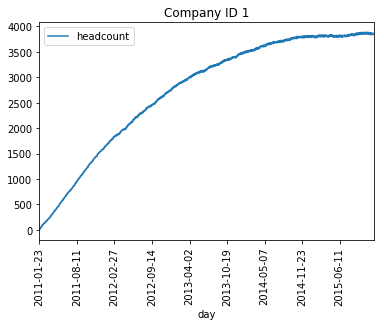

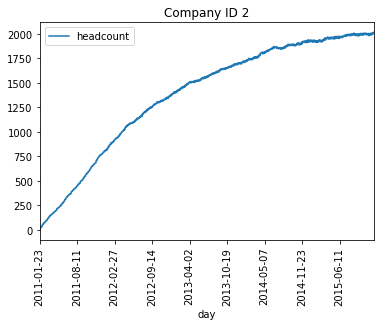

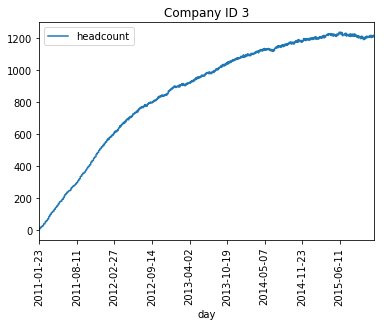

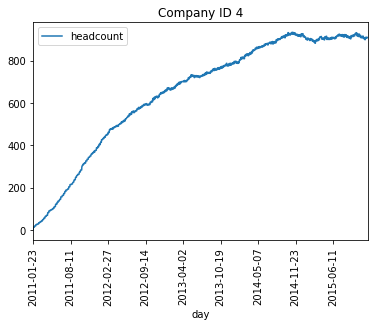

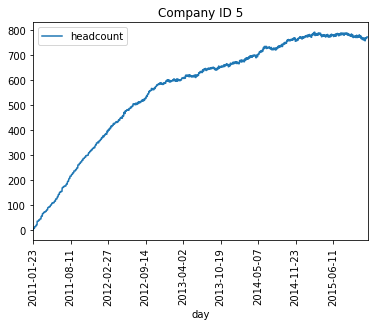

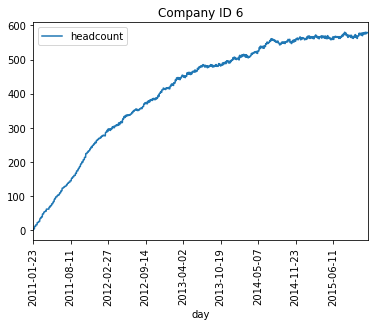

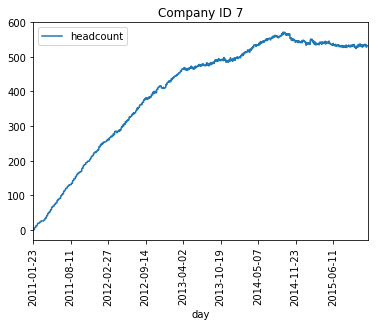

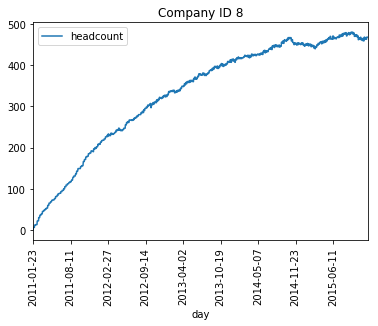

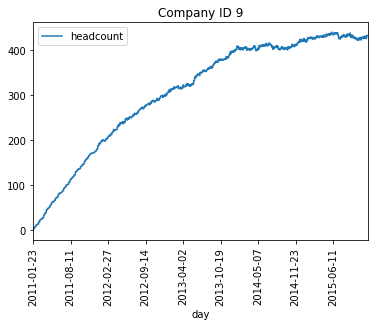

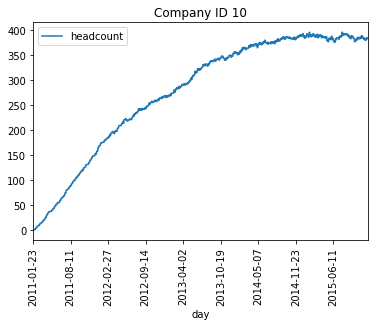

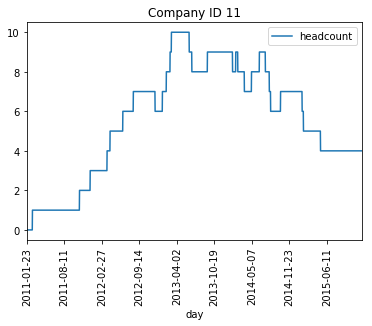

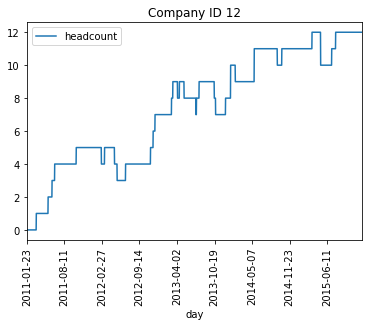

In [6]:
# Let's visualize how each company is doing with the headcount. 

for key, grp in headcount_df.groupby(['company_id']):
    grp.plot(x='day', y='headcount')
    plt.title("Company ID " + str(key))
    plt.xticks(rotation='vertical')
    plt.show()

Based on final headcounts, the company ID is inversely proportional to the size of the company; companies 1 through 12 appear to be ranked in descending order of size. The behavior of employees over time is fairly similar across companies, particularly for the "large" companies (1 - 10), growing pretty quickly over the first few years and hitting a plateau. The similarity of these growth curves means that as a first pass, it might be reasonable to look for common drivers of employee churn across companies. I'll start by creating a new column for the length of an employee's employment.

In [7]:
join_dates = [day_as_dt(row[1]["join_date"]) for row in employee_data.iterrows()]
quit_dates = [day_as_dt(row[1]["quit_date"]) for row in employee_data.iterrows()]
durations = []
for idx, date in enumerate(quit_dates):
    if date is not None:
        duration = (date - join_dates[idx]).days
        durations.append(duration)
    else:
        durations.append(float('nan'))
employee_data['duration'] = durations

In [8]:
print(employee_data.head())  # Just checking that the "durations" column was correctly appended.

   employee_id  company_id              dept  seniority    salary   join_date  \
0      13021.0           7  customer_service         28   89000.0  2014-03-24   
1     825355.0           7         marketing         20  183000.0  2013-04-29   
2     927315.0           4         marketing         14  101000.0  2014-10-13   
3     662910.0           7  customer_service         20  115000.0  2012-05-14   
4     256971.0           2      data_science         23  276000.0  2011-10-17   

    quit_date  duration  
0  2015-10-30     585.0  
1  2014-04-04     340.0  
2         NaN       NaN  
3  2013-06-07     389.0  
4  2014-08-22    1040.0  


If one is interested in employee turnover, a great place to start would be figuring out _how long_ employees tend to work at the company. From there, perhaps it will be possible to identify what is causing employees to leave quickly if they are doing so.  As a first step, I'll visualize the distribution of employment lengths.

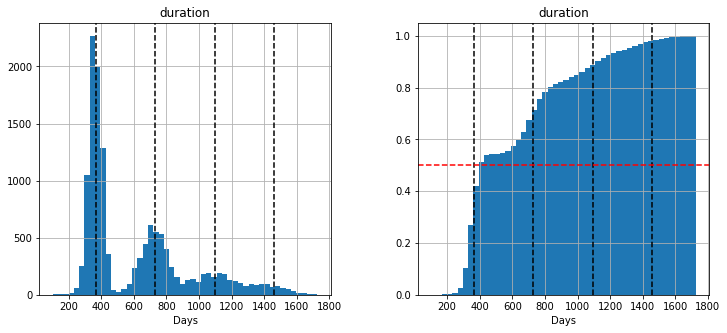

In [9]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xlabel("Days")
ax2.set_xlabel("Days")
employee_data.hist(column="duration", bins=50, ax=ax1)
employee_data.hist(column="duration", bins=50, ax=ax2, cumulative=True, normed=1)
for yr in [1, 2, 3, 4]:
    ax1.axvline(x=365*yr, linestyle='dashed', color='black')
    ax2.axvline(x=365*yr, linestyle='dashed', color='black')
ax2.axhline(y=0.5, linestyle='dashed', color='red')
plt.show()

The histogram of employment lengths above exhibits peaks at every 1-year interval (shown as dashed black lines). In particular, as the cumulative histogram (above, right) demonstrates, nearly half (red dashed line, above right) of the employees who have quit so far do so right around 1 year of employment (with other, smaller leaps at the 2 and 3 year marks).  

By year 2, about 80% of the people who left over the time period of the data collection hvae done so already. It seems sensible, as a first-order attempt at understanding employee churn, to think about employees who leave before 2 years as compared to those who don't. To serve as a basis for a classification model, I'll create a "year2_quitter" category that describes whether an employee has left after 2 years (730 days).

In [10]:
left_after_2 = [row[1]["duration"] <= 730 for row in employee_data.iterrows()]
employee_data["year2_quitter"] = left_after_2

With this created, I'll use a decision tree to figure out what features, if any, drive employees into the "year2_quitter" category. I am one-hot encoding the departments and company IDs because sklearn currently [doesn't play nicely](https://datascience.stackexchange.com/questions/5226/strings-as-features-in-decision-tree-random-forest) with categorical, non-numerical variables. Although the company IDs are integers, they should still be one-hot encoded, because, for example, "Company ID > 4" is not a sensible classification metric.

In [11]:
employee_data_onehot = pd.get_dummies(data=employee_data, columns=["dept", "company_id"])

In [12]:
from sklearn import tree

# Select the classifier features.
classifier_features = employee_data_onehot[["company_id_1", 
                                            "company_id_2",
                                            "company_id_3",
                                            "company_id_4",
                                            "company_id_5",
                                            "company_id_6",
                                            "company_id_7",
                                            "company_id_8",
                                            "company_id_9",
                                            "company_id_10",
                                            "company_id_11",
                                            "company_id_12",
                                            "dept_customer_service", 
                                            "dept_data_science",
                                            "dept_design",
                                            "dept_engineer",
                                            "dept_marketing",
                                            "dept_sales",
                                            "seniority", 
                                            "salary"]]

# Build the decision tree.
employee_clf = tree.DecisionTreeClassifier()
employee_clf = employee_clf.fit(classifier_features, employee_data_onehot["year2_quitter"])

First, let's look at the importance of each feature.

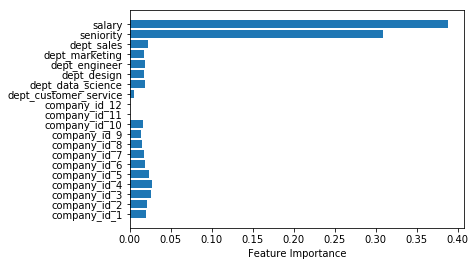

In [13]:
feature_labels = []
feature_importances = []
for name, importance in zip(classifier_features.columns, employee_clf.feature_importances_):
    feature_labels.append(name)
    feature_importances.append(importance)
plt.barh(range(len(feature_importances)), feature_importances)
plt.yticks(range(len(feature_importances)), feature_labels)
plt.xlabel("Feature Importance")
plt.show()

The feature importance plot above makes it clear that salary and seniority affect rapid (less than 2 years at the company) turnover most strongly. I can get even more insight as to what types of salaries and experience levels are driving this churn by visualizing the tree, which is accomplished [using graphviz](http://scikit-learn.org/stable/modules/tree.html). If you are running this notebook locally and don't have graphviz, feel free to comment out the cell below -- the visualization of the tree isn't crucial in understanding the conclusions of my analysis.

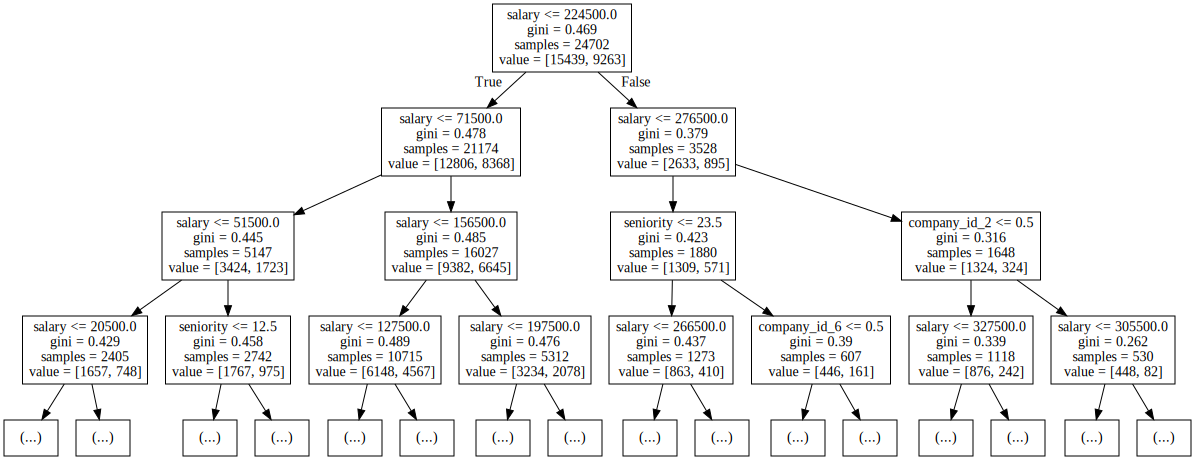

In [14]:
import graphviz
dot_data = tree.export_graphviz(employee_clf, out_file=None, max_depth=3, feature_names=feature_labels)
graph = graphviz.Source(dot_data)
graph

To get a better understanding of what types of salaries are leaving, I'll visualize the distribution of salary for employees who quit within 2 years and employees who did not.

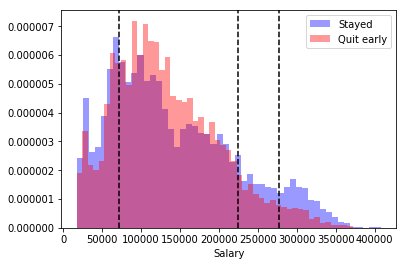

In [15]:
# Select all of the employees that stayed at the companies and get their salary data.
emp_stayed = employee_data.loc[employee_data["year2_quitter"] == False]
stayed_salary_data = emp_stayed['salary'].values

# Select all of the employees woh left within 2 years and get their salary data.
quitters = employee_data.loc[employee_data["year2_quitter"] == True]
quitter_salary_data = quitters['salary'].values

# Generate overlayed, normalized histograms of both salary sets.
plt.hist(stayed_salary_data, normed=1, alpha=0.4, color='blue', bins=50, label='Stayed')
plt.hist(quitter_salary_data, normed=1, alpha=0.4, color='red', bins=50, label='Quit early')

# Add vertical dashed lines to visualize decision boundaries.
for d_b in [71500, 224500, 276500]:
    plt.axvline(x=d_b, linestyle='dashed', color='black')

# Display the plot.
plt.xlabel("Salary")
plt.legend()
plt.show()

The dashed black lines above show the salaries used as the top splits on the decision tree. Betweeen \$71,500/yr and \$224,500/yr, the red histogram, which shows the salaries of employees that left their company within 2 years, is clearly elevated relative to the salaries of those who stayed longer than two years (blue years). The opposite is true above \$224,500/yr - there are relatively more employees who stayed in this pay bracket. It would be interested to know if seniority is playing a lesser role in tihs behavior - a hypothesis is that employees with more seniority but lower salaries (relatively speaking) may be more inclined to leave.  I'll visualize salaries as a function of seniority and highlight the "at-risk" band (\$71,500/yr to \$224,500/yr) in red.

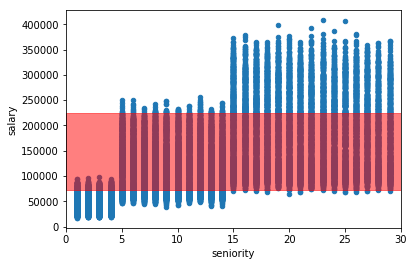

In [16]:
employee_data.plot.scatter(x='seniority', y='salary')
plt.xlim([0,30])
plt.axhspan(71500, 224500, alpha=0.5, color='red')
plt.show()

The "at-risk" band (red, above) covers basically the whole 5-15 year seniority bracket, with about half of the more senior employees also falling into this bracket. As a complement to this analysis, I'll visualize the distribution of seniority in the "at-risk" pay band between employees that left and employees that stayed. If high-seniority employees show elevated representation here, the underpayment of senior employees could be a factor in employee churn.

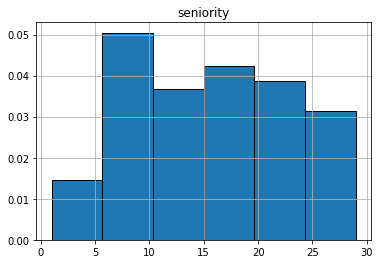

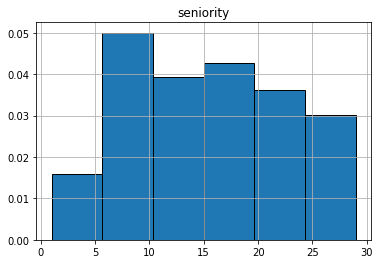

In [17]:
# Get all of the people in the at-risk pay band who left before 2 years and generate a histogram of their seniority.
at_risk_df = quitters.loc[(quitters['salary'] >= 71500) & (quitters['salary'] <= 224500)]
at_risk_df.hist(column='seniority', cumulative=False, normed=1, bins=6, edgecolor='black')

# Get all of the people in the at-risk band who didn't leave before 2 years (minus two probable errors with >90 years experience) and generate a histogram of their seniority.
at_risk_stayed = emp_stayed.loc[(emp_stayed['salary'] >= 71500) & (emp_stayed['salary'] <= 224500) & (employee_data['seniority'] < 90)]
at_risk_stayed.hist(column='seniority', bins=6, cumulative=False, normed=1, edgecolor='black')

# Display the plots
plt.show()

Because these distributions are nearly identical, it seems that seniority _isn't_ playing a strong role in determining whether an employee leaves once they are in the "at-risk" pay band. To finalize the analysis, I'll display a Kaplan-Meier survivial analysis of employees in 3 pay bands:

1. In the at-risk pay band (\$71,500 > salary < \$224,500)
2. Below the at-risk pay band (salary < \$71,500)
3. Above the at-risk pay band (salary > \$224,500)

In [18]:
# To do the K-M analysis, I need one more column - whether the employee quit during the duration of the data collection.
quit_observed = []
for row in employee_data.iterrows():
    if str(row[1]["quit_date"]) == 'nan':
        quit_observed.append(0)
    else:
        quit_observed.append(1)

In [23]:
# Create this a DataFrame column and display to make sure it was added correctly.
employee_data['quit_observed'] = quit_observed
print(employee_data.head())

   employee_id  company_id              dept  seniority    salary   join_date  \
0      13021.0           7  customer_service         28   89000.0  2014-03-24   
1     825355.0           7         marketing         20  183000.0  2013-04-29   
2     927315.0           4         marketing         14  101000.0  2014-10-13   
3     662910.0           7  customer_service         20  115000.0  2012-05-14   
4     256971.0           2      data_science         23  276000.0  2011-10-17   

    quit_date  duration  year2_quitter  quit_observed  
0  2015-10-30     585.0           True              1  
1  2014-04-04     340.0           True              1  
2         NaN       NaN          False              0  
3  2013-06-07     389.0           True              1  
4  2014-08-22    1040.0          False              1  


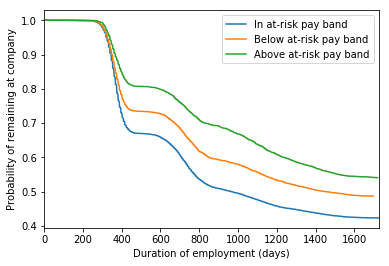

In [37]:
from lifelines import KaplanMeierFitter  # Import the KaplanMeierFitter

# Create a fitter
kmf = KaplanMeierFitter()

# Partition the employee data into the 3 pay pands described above.
in_at_risk = employee_data.loc[(employee_data['salary'] >= 71500) & (employee_data['salary'] <= 224500)]
below_at_risk = employee_data.loc[employee_data['salary'] < 71500]
above_at_risk = employee_data.loc[employee_data['salary'] > 224500]

# Do the KMF fitting and plot the functions.
fig = plt.figure()
ax = fig.add_subplot(111)

kmf.fit(in_at_risk['duration'], in_at_risk['quit_observed'], label="In at-risk pay band")
kmf.survival_function_.plot(ax=ax)
kmf.fit(below_at_risk['duration'], below_at_risk['quit_observed'], label="Below at-risk pay band")
kmf.survival_function_.plot(ax=ax)
kmf.fit(above_at_risk['duration'], above_at_risk['quit_observed'], label="Above at-risk pay band")
kmf.survival_function_.plot(ax=ax)

# Display the plot
plt.ylabel("Probability of remaining at company")
plt.xlabel("Duration of employment (days)")
plt.show()

## Conclusion ##

Employees in the \$71,500 - \$224,500 pay bracket (labeled as the "at-risk" pay band in the above analysis) have an approximately 10% higher chance of leaving after a year of employment than employees below this pay bracket, and a 20% higher chance of leaving than employees above this pay bracket. A decision analysis reveals that salary is the primary determining factor for employee turnover and that salary has a much larger impact than seniority, department, or company. It is also clear that employees tend to leave at 1-year intervals.

* The higher turnover for employees in the middle salary bracket makes sense. Employees below the at-risk salary range may have less employable skillsets and are more likely to be inexperienced, so there is a better chance these employees will stay, either because it is more difficult to find work elsewhere or to "put in their time" at the company. Employees above the at-risk salary range are extremely well-compensated and don't have much incentive to leave (plus, jobs at this salary level are likely approaching the C-suite and may be scarce). **Inside** the at-risk pay band, employees are well-compensated enough that they likely have a fairly in-demand skillset, but at the same time are not so highly ranked that jobs at their level are rare, creating a perfect recipe for turnover.

* It is difficult to make actionable recommendations on this data set alone. Employers should pay particular attention to employees who are nearing 1-year intervals on their employment and in the "at-risk" pay bracket and consider incentives that improve retention of these employees. Beyond that, the single most useful variable to add to this data set would be "time since last raise" - this would allow me to analyze the impact of offering raises on employee retention and whether offering a raise at the right time could reduce turnover in the "at-risk" pay bracket. As it stands, it is not known how long a given employee has been in that pay bracket, which may be an important factor in determining whether said employee leaves the company.